# 2D Fourier Signal Spatial Analysis

In [1]:
# 2D Fourier Signal Analysis For spatial differentials
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import convolve2d
from scipy.ndimage import laplace
import time

def plotGrid(A):
    X = []
    Y = []
    C = []
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            X.append(i)
            Y.append(j)
            C.append(np.real(A[i,j]))
    return X,Y,C


def PRMSE(A, B):
    return np.sqrt(np.mean(A - B) ** 2) / np.sqrt(np.mean(B ** 2))

In [2]:
#DiamondSquare.py
#Written by Hailey K Buckingham
#On github, buckinha/DiamondSquare
#

import random
import numpy as np

def diamond_square(desired_size, min_height, max_height, roughness, random_seed=None, AS_NP_ARRAY=False, USE_NEW_SQUARE_STEP=True):
    """Runs a diamond square algorithm and returns an array (or list) with the landscape
        An important difference (possibly) between this, and other implementations of the 
    diamond square algorithm is how I use the roughness parameter. For each "perturbation"
    I pull a random number from a uniform distribution between min_height and max_height.
    I then take the weighted average between that value, and the average value of the 
    "neighbors", whether those be in the diamond or in the square step, as normal. The 
    weights used for the weighted sum are (roughness) and (1-roughness) for the random
    number and the average, respectively, where roughness is a float that always falls 
    between 0 and 1.
        The roughness value used in each iteration is based on the roughness parameter
    passed in, and is computed as follows:
        this_iteration_roughness = roughness**iteration_number
    where the first iteration has iteration_number = 0. The first roughness value 
    actually used (in the very first diamond and square step) is roughness**0 = 1. Thus,
    the values for those first diamond and square step entries will be entirely random.
    This effectively means that I am seeding with A 3x3 grid of random values, rather 
    than with just the four corners.
        As the process continues, the weight placed on the random number draw falls from
    the original value of 1, to roughness**1, to roughness**2, and so on, ultimately 
    approaching 0. This means that the values of new cells will slowly shift from being
    purely random, to pure averages.
    OTHER NOTES:
    Internally, all heights are between 0 and 1, and are rescaled at the end.
    PARAMETERS
    ----------
    size
        The size of the grid to be returned. If an integer is passed, the return grid will
        have sides of this length. If an array-like is passed, the first two values will be 
        used as the array shape.
    min_height
        The minimum height allowed on the landscape
    max_height
        The maximum height allowed on the landscape
    roughness
        A float with value between 0 and 1, reflecting how bumpy the landscape should be. 
        Values near 1 will result in landscapes that are extremly rough, and have almost no
        cell-to-cell smoothness. Values near zero will result in landscapes that are almost
        perfectly smooth.
    random_seed
        defaults to None. If a value is given, the algorithm will use it to seed the random
        number generator, ensuring replicability.
    AS_NP_ARRAY
        A boolean reflecting whether the landscape should be returned as a numpy array. If set
        to False, the method will return a 2-dimensional list.
    RETURNS
    -------
    A 2-D numpy array or 2-D list with a diamond-square "height-map"
    """
    #sanitize inputs
    if roughness > 1: roughness = 1.0
    if roughness < 0: roughness = 0.0
    
    #check if size is iterable (i.e, it is likely a length-2 vector, etc...)
    size = [-1,-1]
    if not hasattr(desired_size, '__iter__'):
        #it's not iterable, so it's probably an int
        size[0] = desired_size
        size[1] = desired_size
    else:
        size[0] = desired_size[0]
        size[1] = desired_size[1]


    DS_size, iterations = get_DS_size_and_iters(size)

    #create the array
    #DS_array = np.ndarray((DS_size,DS_size))
    DS_array = np.zeros((DS_size,DS_size), dtype='float')
    DS_array = DS_array - 1.0

    #seed the random number generator
    random.seed(random_seed)


    #seed the corners
    DS_array[        0,         0] = random.uniform(0, 1)
    DS_array[DS_size-1,         0] = random.uniform(0, 1)
    DS_array[        0, DS_size-1] = random.uniform(0, 1)
    DS_array[DS_size-1, DS_size-1] = random.uniform(0, 1)


    #do the algorithm
    for i in range(iterations):
        r = roughness**i

        step_size = (DS_size-1) // 2**(i)

        diamond_step(DS_array, step_size, r)

        if USE_NEW_SQUARE_STEP: 
            square_step(DS_array, step_size, r)
        else:
            square_step_original(DS_array, step_size, r)



    #rescale the array to fit the min and max heights specified
    DS_array = min_height + (DS_array * (max_height - min_height))

    #trim array, if needed

    final_array = DS_array[:size[0],:size[1]]

    if AS_NP_ARRAY:
        return final_array
    else:
        return final_array.tolist()


def get_DS_size_and_iters(requested_size, max_power_of_two=13):
    """Returns the necessary size for a square grid which is usable in a DS algorithm.
    The Diamond Square algorithm requires a grid of size n x n where n = 2**x + 1, for any 
    integer value of x greater than two. To accomodate a requested map size other than these
    dimensions, we simply create the next largest n x n grid which can entirely contain the
    requested size, and return a subsection of it.
    This method computes that size.
    PARAMETERS
    ----------
    requested_size
        A 2D list-like object reflecting the size of grid that is ultimately desired.
    max_power_of_two
        an integer greater than 2, reflecting the maximum size grid that the algorithm can EVER
        attempt to make, even if the requested size is too big. This limits the algorithm to 
        sizes that are manageable, unless the user really REALLY wants to have a bigger one.
        The maximum grid size will have an edge of size  (2**max_power_of_two + 1)
    RETURNS
    -------
    An integer of value n, as described above.
    """
    if max_power_of_two < 3: max_power_of_two = 3

    largest_edge = max(requested_size)

    for power in range(1,max_power_of_two+1):
        d = (2**power) + 1
        if largest_edge <= d:
            return d, power

    #failsafe: no values in the dimensions array were allowed, so print a warning and return
    # the maximum size.
    d = 2**max_power_of_two + 1
    print("DiamondSquare Warning: Requested size was too large. Grid of size {0} returned""".format(d))
    return d, max_power_of_two


def diamond_step(DS_array, step_size, roughness):
    """Does the diamond step for a given iteration.
    During the diamond step, the diagonally adjacent cells are filled:
    Value   None   Value   None   Value  ...
    None   FILLING  None  FILLING  None  ...
 
    Value   None   Value   None   Value  ...
    ...     ...     ...     ...    ...   ...
    So we'll step with increment step_size over BOTH axes
    """

    #calculate where all the diamond corners are (the ones we'll be filling)
    half_step = step_size//2
    x_steps = range(half_step, DS_array.shape[0], step_size)
    y_steps = x_steps[:]


    for i in x_steps:
        for j in y_steps:
            if DS_array[i,j] == -1.0:
                #print(repr((i,j)))
                DS_array[i,j] = diamond_displace(DS_array, i, j, half_step, roughness)

def square_step(DS_array, step_size, roughness):
    """Does the square step for a given iteration.
    During the diamond step, the diagonally adjacent cells are filled:
     Value    FILLING    Value    FILLING   Value   ...
    FILLING   DIAMOND   FILLING   DIAMOND  FILLING  ...
 
     Value    FILLING    Value    FILLING   Value   ...
      ...       ...       ...       ...      ...    ...
    So we'll step with increment step_size over BOTH axes
    """

    #doing this in two steps: the first, where the every other column is skipped
    # and the second, where every other row is skipped. For each, iterations along
    # the half-steps go vertically or horizontally, respectively.


    #set the half-step for the calls to square_displace
    half_step = step_size//2

    #vertical step
    steps_x_vert = range(  half_step , DS_array.shape[0]  ,   step_size)
    steps_y_vert = range(  0         , DS_array.shape[1]  ,   step_size)

    #horizontal step
    steps_x_horiz = range(  0         , DS_array.shape[0] ,   step_size)
    steps_y_horiz = range(  half_step , DS_array.shape[1] ,   step_size)


    for i in steps_x_horiz:
        for j in steps_y_horiz:
            DS_array[i,j] = square_displace(DS_array, i, j, half_step, roughness)

    for i in steps_x_vert:
        for j in steps_y_vert:
            DS_array[i,j] = square_displace(DS_array, i, j, half_step, roughness)



    #ORIGINAL METHOD, which iterates over a lot of extra cells
    # steps_x = range(          0, DS_array.shape[0], half_step)
    # steps_y = range(          0, DS_array.shape[0], half_step)

    # for i in steps_x:
    #     for j in steps_y:
    #         if DS_array[i,j] == -1.0:
    #             DS_array[i,j] = square_displace(DS_array, i, j, half_step, roughness)

def square_step_original(DS_array, step_size, roughness):
    """Does the square step for a given iteration.
    During the diamond step, the diagonally adjacent cells are filled:
     Value    FILLING    Value    FILLING   Value   ...
    FILLING   DIAMOND   FILLING   DIAMOND  FILLING  ...
 
     Value    FILLING    Value    FILLING   Value   ...
      ...       ...       ...       ...      ...    ...
    So we'll step with increment step_size over BOTH axes
    """

    #doing this in two steps: the first, where the every other column is skipped
    # and the second, where every other row is skipped. For each, iterations along
    # the half-steps go vertically or horizontally, respectively.

    half_step = step_size//2

    steps_x = range(          0, DS_array.shape[0], half_step)
    steps_y = range(          0, DS_array.shape[0], half_step)

    for i in steps_x:
        for j in steps_y:
            if DS_array[i,j] == -1.0:
                DS_array[i,j] = square_displace(DS_array, i, j, half_step, roughness)

#defines the midpoint displacement for the diamond step
def diamond_displace(DS_array, i, j, half_step, roughness):
    ul = DS_array[i-half_step, j-half_step]
    ur = DS_array[i-half_step, j+half_step]
    ll = DS_array[i+half_step, j-half_step]
    lr = DS_array[i+half_step, j+half_step]

    ave = (ul + ur + ll + lr)/4.0

    rand_val = random.uniform(0,1)

    return (roughness*rand_val + (1.0-roughness)*ave)


#defines the midpoint displacement for the square step
def square_displace(DS_array, i, j, half_step, roughness):
    _sum = 0.0
    divide_by = 4

    #check cell "above"
    if i - half_step >= 0:
        _sum += DS_array[i-half_step, j]
    else:
        divide_by -= 1

    #check cell "below"
    if i + half_step < DS_array.shape[0]:
        _sum += DS_array[i+half_step, j]
    else:
        divide_by -= 1

    #check cell "left"
    if j - half_step >= 0:
        _sum += DS_array[i, j-half_step]
    else:
        divide_by -= 1

    #check cell "right"
    if j + half_step < DS_array.shape[0]:
        _sum += DS_array[i, j+half_step]
    else:
        divide_by -= 1


    ave = _sum / divide_by

    rand_val = random.uniform(0,1)

    return (roughness*rand_val + (1.0-roughness)*ave)

## Creating Random Data

In [5]:
N = 200
M = 20
stride_length = 0.1

R = np.random.rand(N,N)

## Creating Random Walk Data

In [6]:
# RW = np.zeros((N, N))
# tGrid = np.zeros((N,N)) + 1
# for x in range(1, N):
#     for y in range(1, N):
#         RW[x, y] =0.5 * RW[x-1, y] + (R[x, y]-0.5) + 0.5 * RW[x, y-1]
RW = np.array(diamond_square((N,N),1,100,0.5,random_seed=5))/100.0

## Creating Truncation of Fourier Series (Collapsing Data)

In [7]:
tN = 80
tGrid = np.zeros((N,N))
for x in range(1, N):
    for y in range(1, N):
        if x >= N - M or x <M:
            if y >= N-M or y<M:
                tGrid[x, y] = 1


## Measuring Loss

In [8]:
FR = np.fft.fft2(R)
FRW = np.fft.fft2(RW)

print("random error: {}".format(PRMSE(np.fft.ifft2(FR), R)))
print("random error: {}".format(PRMSE(np.fft.ifft2(FRW), RW)))
print("random error: {}".format(PRMSE(np.fft.ifft2(FR*tGrid), R)))
print("random error: {}".format(PRMSE(np.fft.ifft2(FRW * tGrid), RW)))

random error: (5.898363648227657e-17-2.5537616313057526e-34j)
random error: (6.867388189892724e-17-2.696920953109526e-34j)
random error: (0.8671891387159343+3.1148866480175323e-20j)
random error: (0.9890105531392055-1.9274423656388266e-21j)


## Displaying Differences

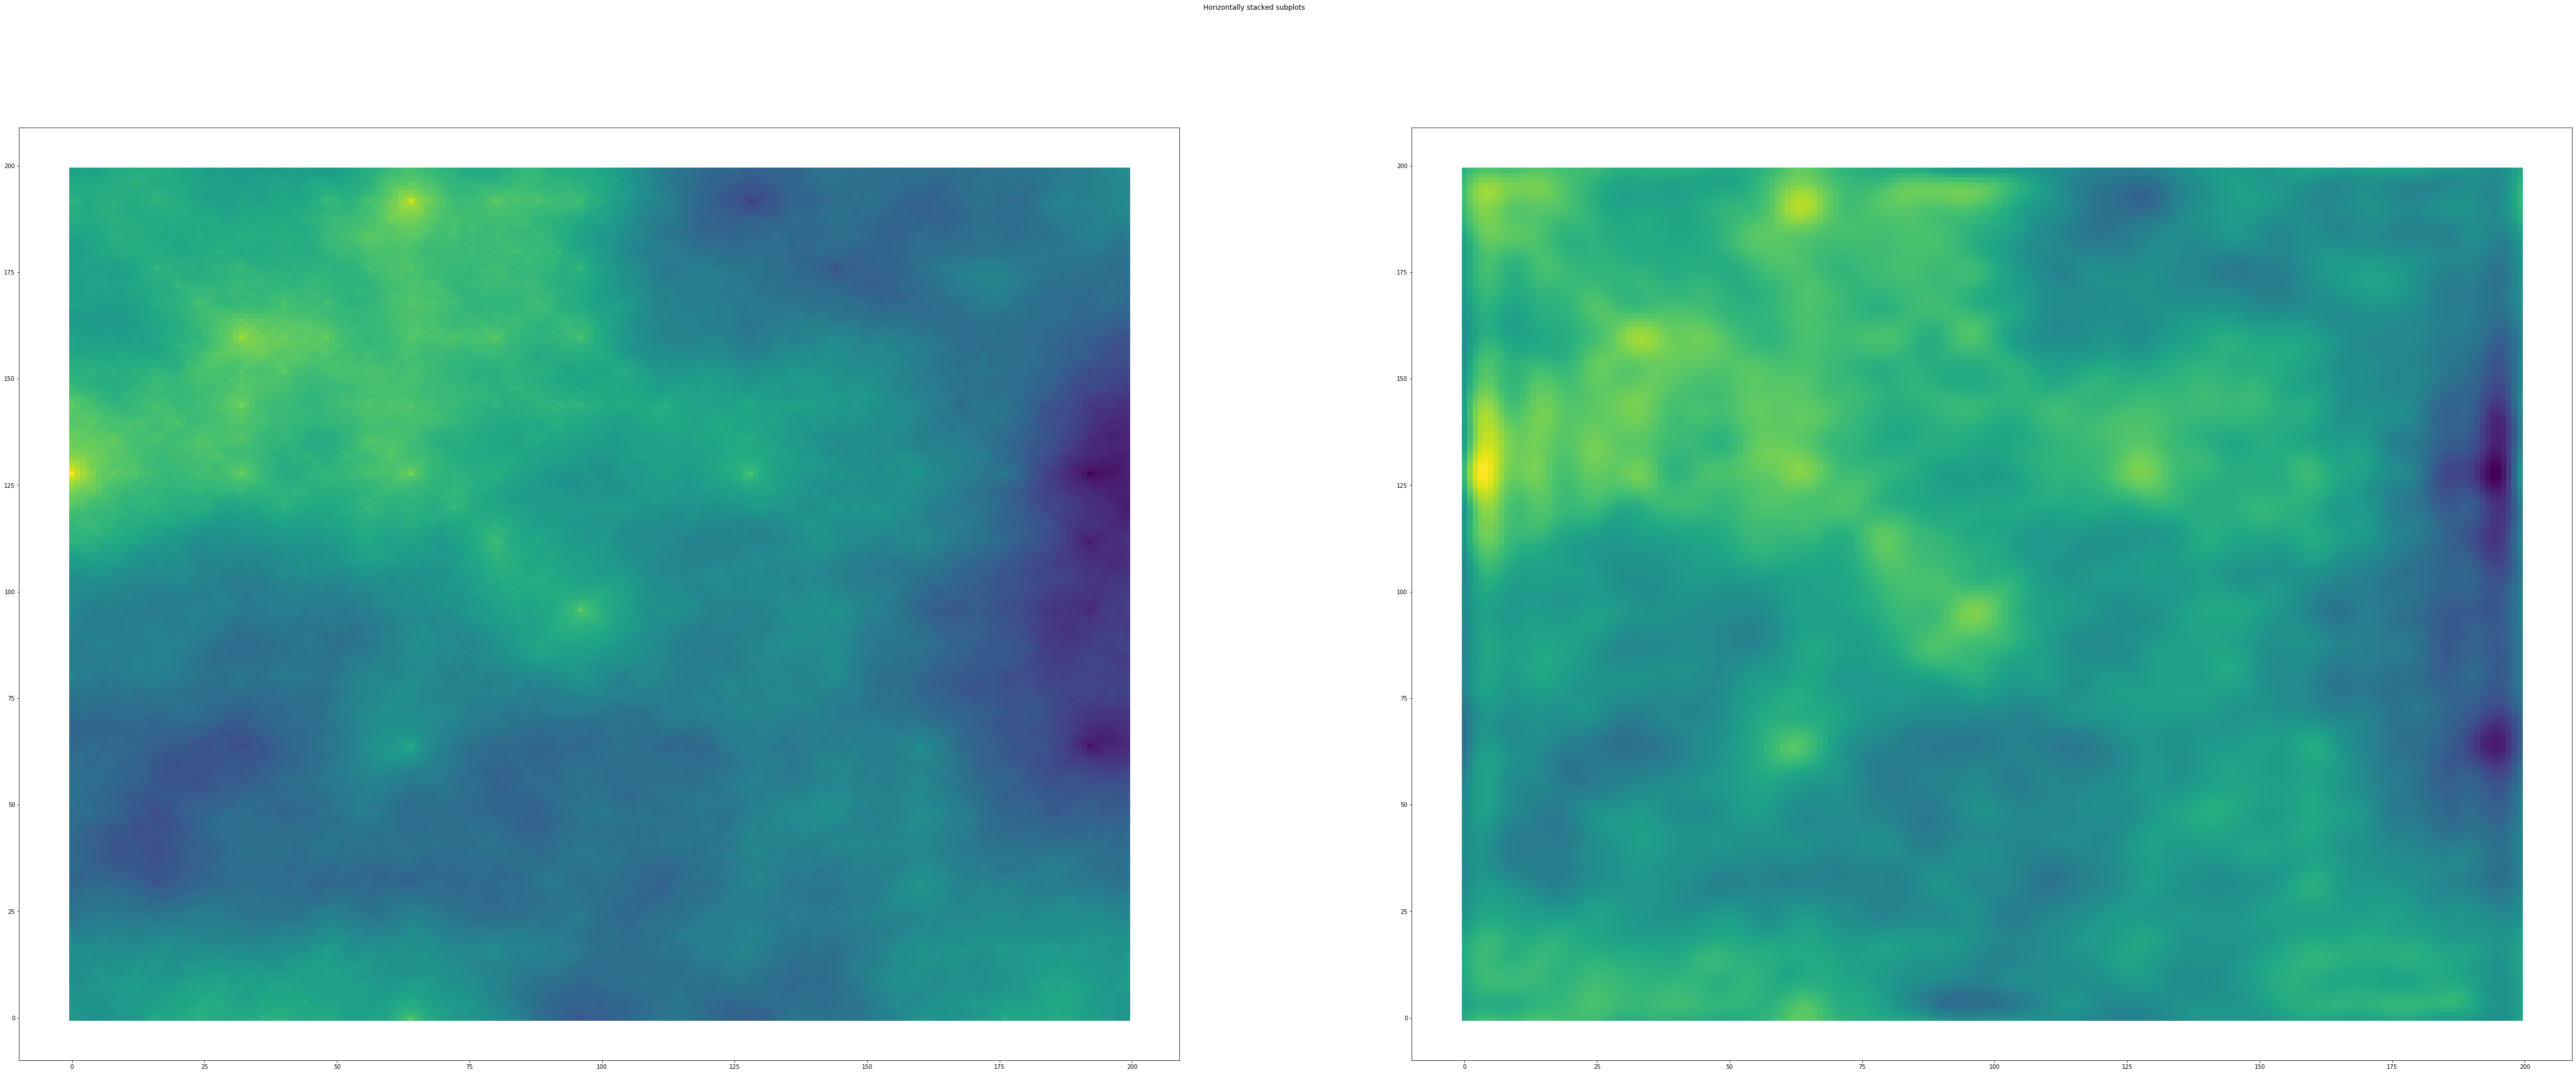

In [9]:
px = (18*100/N)**2
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
fig.set_figheight(30)
fig.set_figwidth(80)
ax1.scatter(plotGrid(RW)[0], plotGrid(RW)[1], c=plotGrid(RW)[2], s=px, marker='s')
ax2.scatter(plotGrid(np.fft.ifft2(FRW*tGrid[::-1, ::-1]))[0], plotGrid(np.fft.ifft2(FRW*tGrid[::-1, ::-1]))[1], c=plotGrid(np.fft.ifft2(FRW*tGrid[::-1, ::-1]))[2], s=px, marker='s')



In [10]:
np.mean(tGrid)

0.038025

## Measuring Divergence

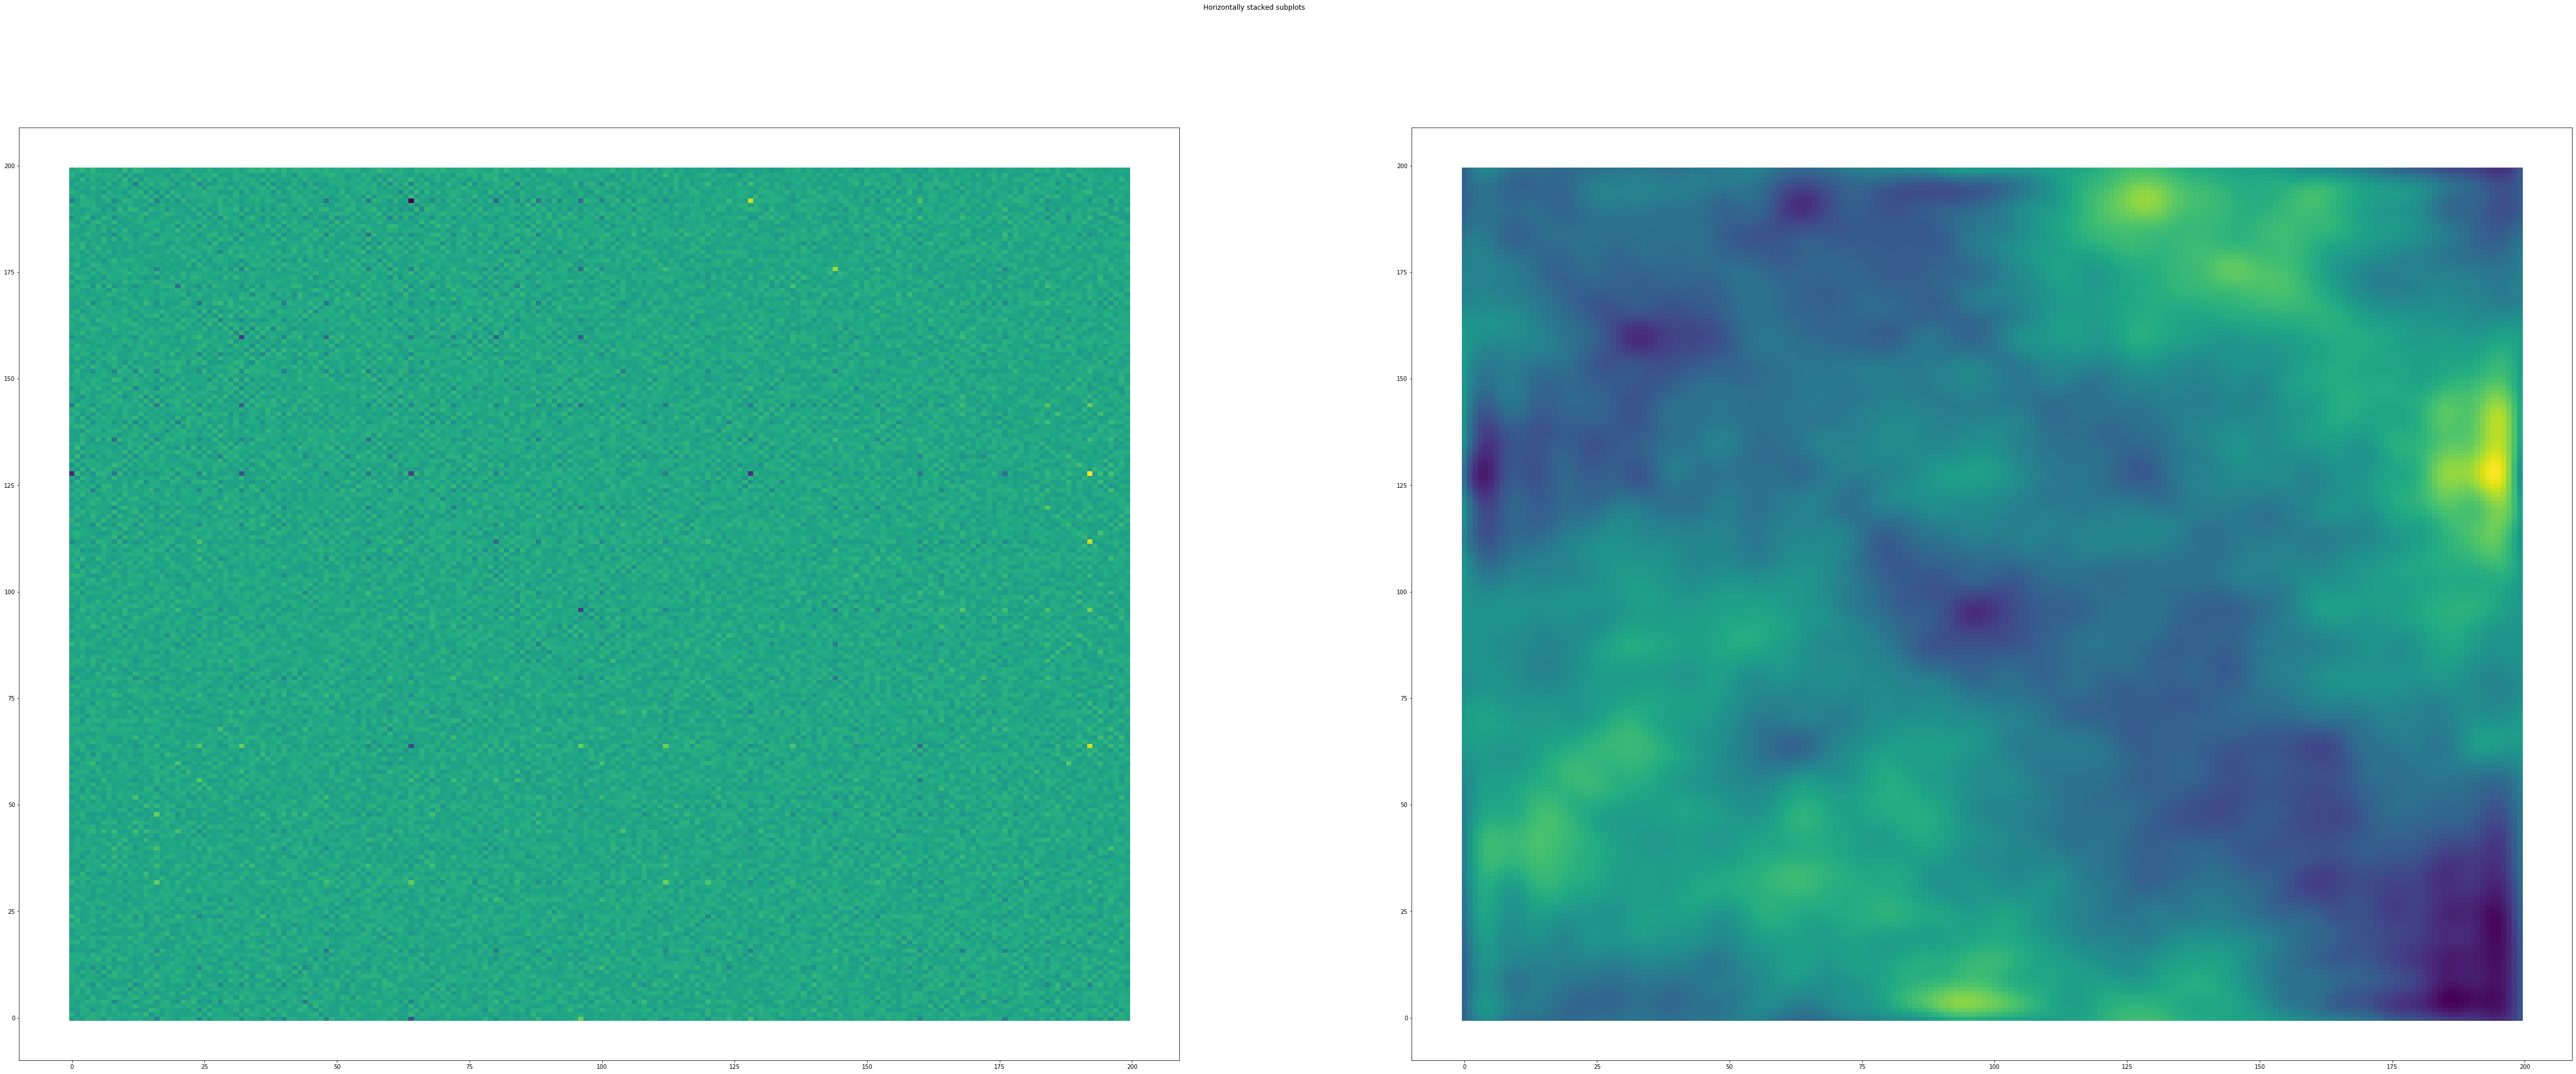

In [11]:
divGrid = np.zeros((N,N))
for x in range(0, N):
    for y in range(0, N):
        divGrid[x,y] = -4 * np.pi * (x**2 + y**2)

        
div1 = np.fft.ifft2(FRW*divGrid*tGrid)
div2 = np.fft.ifft2(FRW)
div2 = laplace(RW)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
fig.set_figheight(30)
fig.set_figwidth(80)
ax1.scatter(plotGrid(div2)[0], plotGrid(div2)[1], c=plotGrid(div2)[2], s=px, marker='s')
ax2.scatter(plotGrid(div1)[0], plotGrid(div1)[1], c=plotGrid(div1)[2], s=px, marker='s')


In [12]:
RW2 = np.array(diamond_square((N,N),1,100,0.5,random_seed=7))/100.0
FRW2 = np.fft.fft2(RW2)

## Measuring accuracy of multiplication

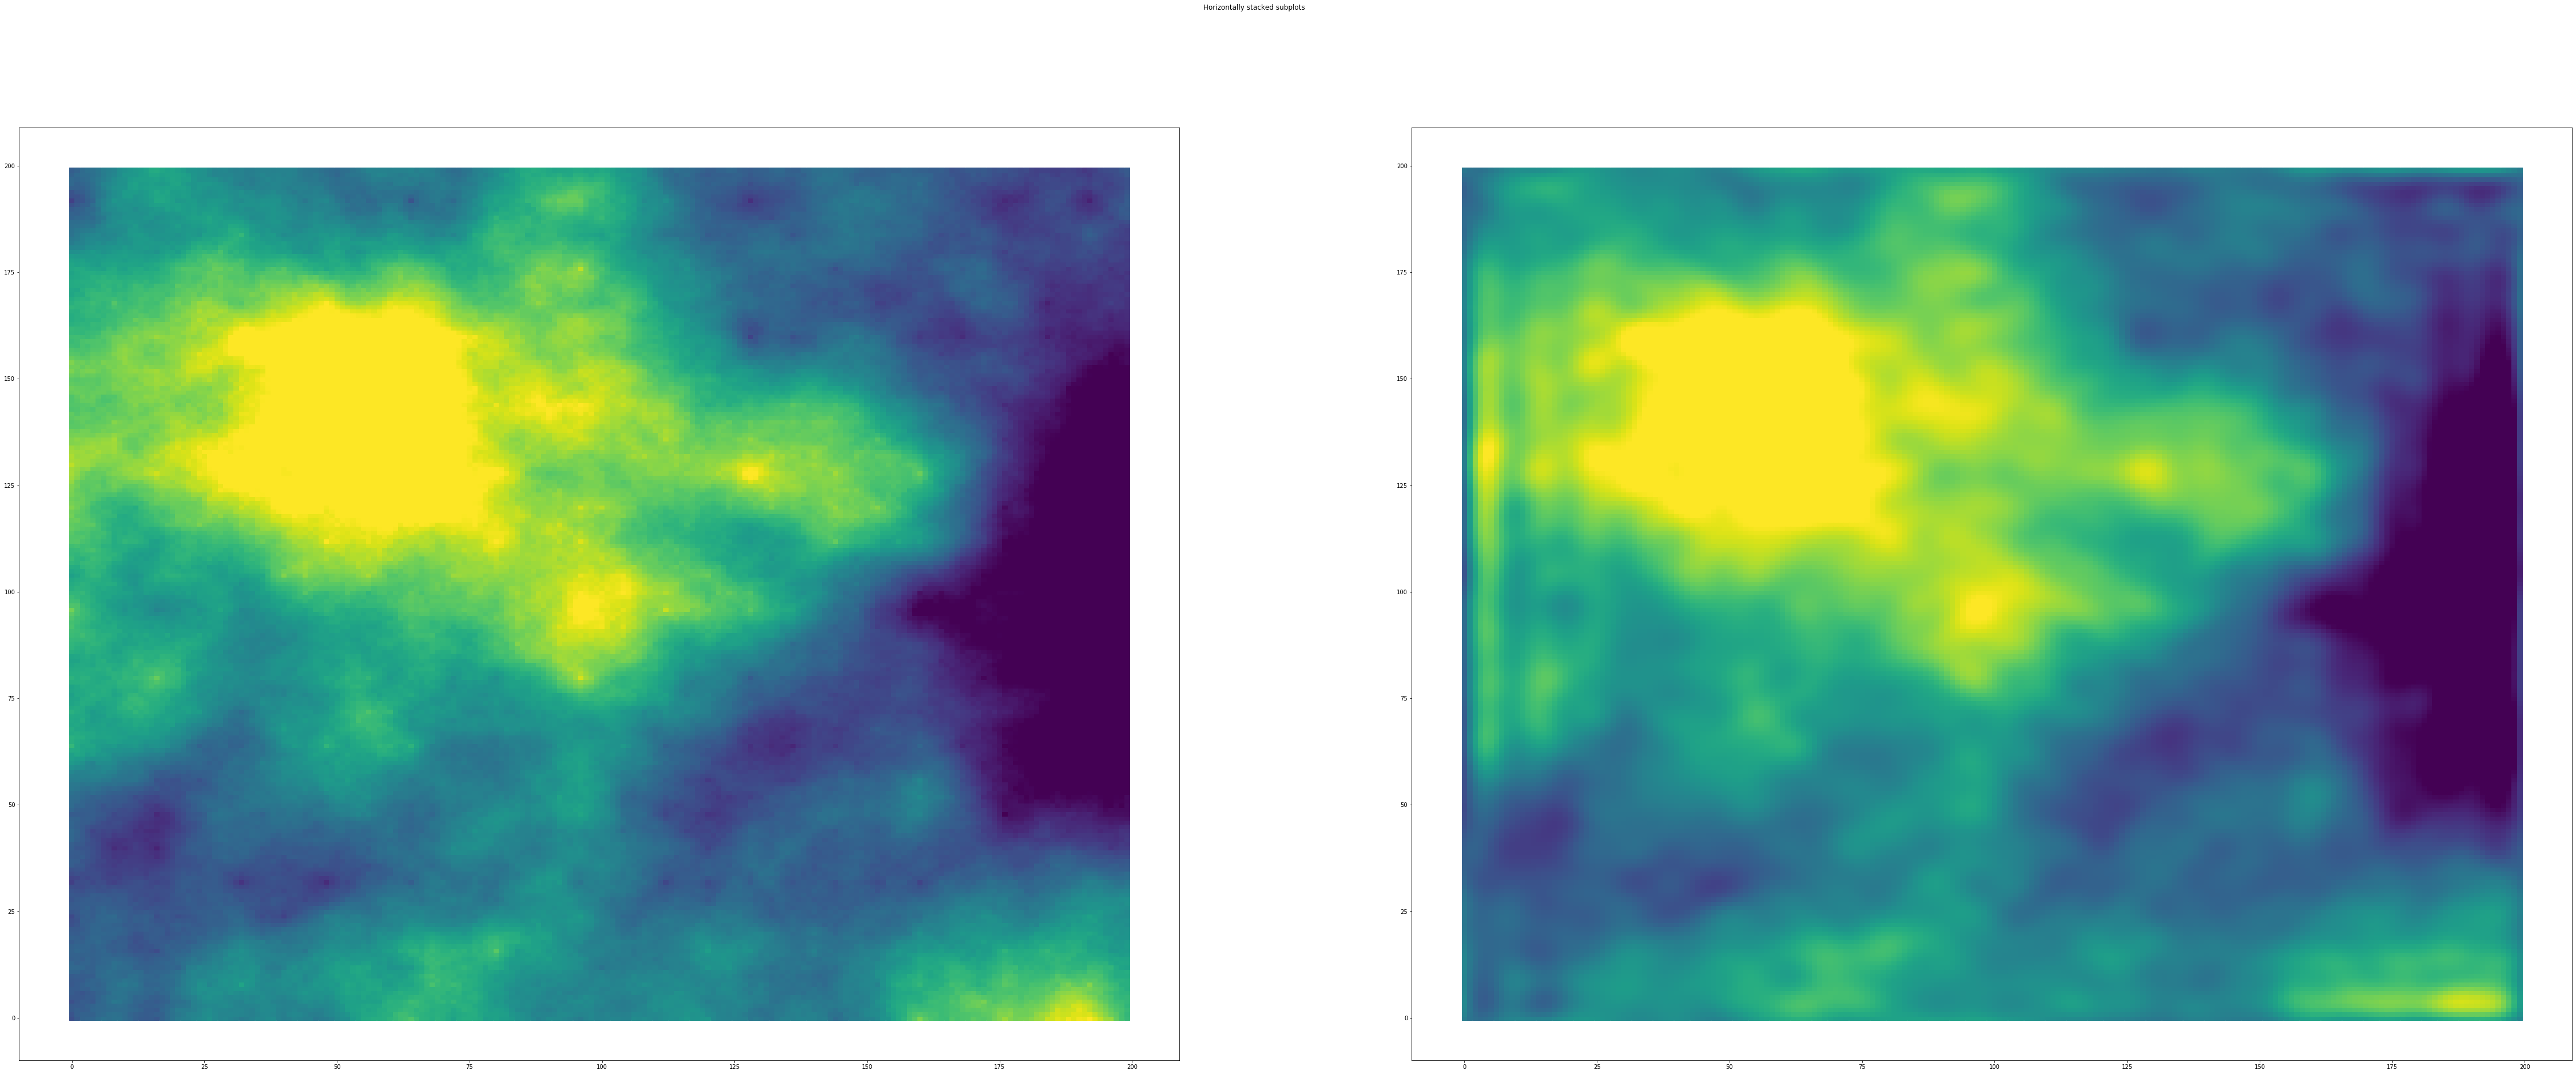

In [13]:
FL = [FRW[:M, :M], FRW[N-M:, :M], FRW[N-M:, N-M:], FRW[:M, N-M:]]
FL2 = [FRW2[:M, :M], FRW2[N-M:, :M], FRW2[N-M:, N-M:], FRW2[:M, N-M:]]
CL = [convolve2d(FL[0], FL2[0], mode='full', boundary='fill', fillvalue=0.0)[:M, :M],
      convolve2d(FL[1], FL2[0], mode='full', boundary='fill', fillvalue=0.0)[:M, :M] + convolve2d(FL[0], FL2[1], mode='full', boundary='fill', fillvalue=0.0)[:M, :M],
      convolve2d(FL[1], FL2[3], mode='full', boundary='fill', fillvalue=0.0)[:M, :M]
      + convolve2d(FL[2], FL2[0], mode='full', boundary='fill', fillvalue=0.0)[:M, :M]
      + convolve2d(FL[0], FL2[2], mode='full', boundary='fill', fillvalue=0.0)[:M, :M]
      + convolve2d(FL[3], FL2[1], mode='full', boundary='fill', fillvalue=0.0)[:M, :M],
      convolve2d(FL[3], FL2[0], mode='full', boundary='fill', fillvalue=0.0)[:M, :M] + convolve2d(FL[0], FL2[3], mode='full', boundary='fill', fillvalue=0.0)[:M, :M]
     ]
C = np.r_[np.c_[CL[0], np.zeros((M, N-2*M)), CL[3]], np.zeros((N-2*M, N)), np.c_[CL[1], np.zeros((M, N-2*M)), CL[2]]]
Res1 = RW * RW2
Res2 = np.real(np.fft.ifft2(C) + 1 * 0.25) / 10000
#print("random error: {}".format(PRMSE(Res2, Res1)))
alpha = 0.0
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
fig.set_figheight(30)
fig.set_figwidth(80)
ax1.scatter(plotGrid(Res1)[0], plotGrid(Res1)[1], c=plotGrid(Res1)[2], s=px, marker='s', vmin=np.percentile(np.real(Res1), 5), vmax=np.percentile(np.real(Res1), 95))
ax2.scatter(plotGrid(Res2)[0], plotGrid(Res2)[1], c=plotGrid(Res2)[2], s=px, marker='s', vmin=np.percentile(np.real(Res2), 5), vmax=np.percentile(np.real(Res2), 95))



## Speed of Multiplication

In [14]:
t1 = time.time()
FL = [FRW[:M, :M], FRW[N-M:, :M], FRW[N-M:, N-M:], FRW[:M, N-M:]]
FL2 = [FRW2[:M, :M], FRW2[N-M:, :M], FRW2[N-M:, N-M:], FRW2[:M, N-M:]]
CL = [convolve2d(FL[0], FL2[0], mode='full', boundary='fill', fillvalue=0.0)[:M, :M],
      convolve2d(FL[1], FL2[0], mode='full', boundary='fill', fillvalue=0.0)[:M, :M] + convolve2d(FL[0], FL2[1], mode='full', boundary='fill', fillvalue=0.0)[:M, :M],
      convolve2d(FL[1], FL2[3], mode='full', boundary='fill', fillvalue=0.0)[:M, :M]
     +convolve2d(FL[2], FL2[0], mode='full', boundary='fill', fillvalue=0.0)[:M, :M]
     +convolve2d(FL[0], FL2[2], mode='full', boundary='fill', fillvalue=0.0)[:M, :M]
     +convolve2d(FL[3], FL2[1], mode='full', boundary='fill', fillvalue=0.0)[:M, :M],
      convolve2d(FL[3], FL2[0], mode='full', boundary='fill', fillvalue=0.0)[:M, :M] + convolve2d(FL[0], FL2[3], mode='full', boundary='fill', fillvalue=0.0)[:M, :M]
     ]
C = np.r_[np.c_[CL[0], np.zeros((M, N-2*M)), CL[3]], np.zeros((N-2*M, N)), np.c_[CL[1], np.zeros((M, N-2*M)), CL[2]]]
Res2 = np.real(np.fft.ifft2(C) + 1 * 0.25) / 10000
t2=time.time()
Res1 = RW * RW2
t3 = time.time()
Res3 = np.fft.ifft2(FRW) * np.fft.ifft2(FRW2)
t4 = time.time()

print("via convolution: {}".format(t2 - t1))
print("via multiplication: {}".format(t3 - t2))
print("via FFT multiplication: {}".format(t4 - t3))

via convolution: 0.02310013771057129
via multiplication: 0.0002467632293701172
via FFT multiplication: 0.002946138381958008
